In [512]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PowerTransformer

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers
from sklearn.model_selection import train_test_split

sns.set()
random_state = 123_456
np.random.seed(random_state)

error_tolerance_percentage = 2.5
look_back = 7
batch_size = 8

In [513]:
df = pd.read_csv('fuel-prices/all_features_combined.csv', index_col='date', dtype={'price': np.int32, 
                 'tapis_oil_price': np.int32, 'national_avg_price': np.int32}, parse_dates=True)
df.set_index(pd.date_range(min(df.index), periods=df.shape[0], freq='D'), inplace=True, verify_integrity=True)

In [514]:
features = ['price']
df.shape

(1095, 6)

In [515]:
df = df[features]

In [516]:
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)
del df
df_train.shape

(985, 1)

In [517]:
df_test.shape

(110, 1)

In [518]:
# df_train.describe()

In [519]:
def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [520]:
def get_relative_accuracy(y_test, y_hat, tolerance_percentage):
    it = np.nditer(y_test, flags=['f_index'])
    non_error_count = 0
    
    while not it.finished:
        upper_limit = it[0] * (1 + tolerance_percentage / 100)
        lower_limit = it[0] - (upper_limit - it[0])
        non_error_count += 1 if y_hat[it.index] < upper_limit and y_hat[it.index] > lower_limit else 0
        it.iternext()
        
    return non_error_count / y_test.size

In [521]:
should_standard_scale = True

if should_standard_scale:
    ct = make_column_transformer((MinMaxScaler(), features), verbose=True)
#     ct = make_column_transformer((PowerTransformer(method='box-cox'), features), verbose=True)
#     ct = make_column_transformer((PowerTransformer(method='yeo-johnson'), features), verbose=True)

    result = ct.fit_transform(df_train)
    df_temp = pd.DataFrame(result, columns=features, index=df_train.index)

    for column in features:
        del df_train[column]

    df_train = df_train.merge(df_temp, left_index=True, right_index=True, validate='one_to_one')
    
    result = ct.transform(df_test)
    df_temp = pd.DataFrame(result, columns=features, index=df_test.index)

    for column in features:
        del df_test[column]

    df_test = df_test.merge(df_temp, left_index=True, right_index=True, validate='one_to_one')
    del df_temp
    
    scaler = ct.transformers_[0][1]

[ColumnTransformer] .. (1 of 1) Processing minmaxscaler, total=   0.0s


In [522]:
# counter = look_back

for i in range(look_back):
    df_train['pr_min_{:02d}'.format(i + 1)] = df_train.price.shift(i + 1)
    df_test['pr_min_{:02d}'.format(i + 1)] = df_test.price.shift(i + 1)
#     counter -= 1
    
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [523]:
df_train = df_train[['pr_min_07','pr_min_06','pr_min_05','pr_min_04','pr_min_03','pr_min_02','pr_min_01','price']]
df_test = df_test[['pr_min_07','pr_min_06','pr_min_05','pr_min_04','pr_min_03','pr_min_02','pr_min_01','price']]

In [524]:
df_train[:8]

pr_min_07  pr_min_06  pr_min_05  pr_min_04  pr_min_03  pr_min_02  \
2017-01-08   0.253448   0.286207   0.239655   0.468966   0.537931   0.446552   
2017-01-09   0.286207   0.239655   0.468966   0.537931   0.446552   0.550000   
2017-01-10   0.239655   0.468966   0.537931   0.446552   0.550000   0.512069   
2017-01-11   0.468966   0.537931   0.446552   0.550000   0.512069   0.555172   
2017-01-12   0.537931   0.446552   0.550000   0.512069   0.555172   0.562069   
2017-01-13   0.446552   0.550000   0.512069   0.555172   0.562069   0.551724   
2017-01-14   0.550000   0.512069   0.555172   0.562069   0.551724   0.527586   
2017-01-15   0.512069   0.555172   0.562069   0.551724   0.527586   0.532759   

            pr_min_01     price  
2017-01-08   0.550000  0.512069  
2017-01-09   0.512069  0.555172  
2017-01-10   0.555172  0.562069  
2017-01-11   0.562069  0.551724  
2017-01-12   0.551724  0.527586  
2017-01-13   0.527586  0.532759  
2017-01-14   0.532759  0.515517  
2017-01-15   0.515517  0.534483

In [525]:
# _ = sns.pairplot(df_train)

In [526]:
# df_test[:5]

In [527]:
y_train = df_train.price.shift(-1)
y_train.drop(y_train[y_train.index == '2019-09-12'].index, inplace=True)
df_train.drop(df_train[df_train.index == '2019-09-12'].index, inplace=True)
y_train[:5]

2017-01-08    0.555172
2017-01-09    0.562069
2017-01-10    0.551724
2017-01-11    0.527586
2017-01-12    0.532759
Freq: D, Name: price, dtype: float64

In [528]:
y_test = df_test.price.shift(-1)
y_test.drop(y_test[y_test.index == '2019-12-31'].index, inplace=True)
df_test.drop(df_test[df_test.index == '2019-12-31'].index, inplace=True)
y_test[:5]

2019-09-20    0.598276
2019-09-21    0.606897
2019-09-22    0.624138
2019-09-23    0.608621
2019-09-24    0.593103
Freq: D, Name: price, dtype: float64

In [529]:
# df_train[:1]

In [530]:
# y_train[:1]

In [531]:
df_train.shape

(977, 8)

In [532]:
df_test.shape

(102, 8)

In [533]:
y_train.shape

(977,)

In [534]:
y_test.shape

(102,)

In [535]:
X_train = df_train.values
X_train = np.reshape(X_train, (df_train.shape[0], look_back + 1, len(features)))
X_train = trim_dataset(X_train, batch_size)
X_train.shape

(976, 8, 1)

In [536]:
# X_train[:1]

In [537]:
X_test = df_test.values
X_test = np.reshape(X_test, (df_test.shape[0], look_back + 1, len(features)))
X_test = trim_dataset(X_test, batch_size)
X_test.shape

(96, 8, 1)

In [538]:
y_train = trim_dataset(y_train.values, batch_size)

In [539]:
y_test = trim_dataset(y_test.values, batch_size)

In [540]:
X_train[:1]

array([[[0.25344828],
        [0.2862069 ],
        [0.23965517],
        [0.46896552],
        [0.53793103],
        [0.44655172],
        [0.55      ],
        [0.51206897]]])

In [541]:
y_train[:1]

array([0.55517241])

In [542]:
X_train.shape

(976, 8, 1)

In [543]:
y_train.shape

(976,)

In [544]:
X_test.shape

(96, 8, 1)

In [545]:
y_test.shape

(96,)

In [546]:
model = Sequential()

In [547]:
use_simple_model = True

if use_simple_model:
    model.add(LSTM(64, batch_input_shape=(batch_size, look_back + 1, len(features)), stateful=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
else:
        
    model.add(LSTM(100, batch_input_shape=(batch_size, look_back + 1, len(features)),
                   dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                   kernel_initializer='random_uniform'))

    model.add(Dropout(0.4))
    model.add(LSTM(60, dropout=0.0))
    model.add(Dropout(0.4))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))

    optimizer = optimizers.RMSprop(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

In [548]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (8, 64)                   16896     
_________________________________________________________________
dense_6 (Dense)              (8, 1)                    65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [549]:
history = model.fit(X_train, y_train, epochs=66, verbose=1, batch_size=batch_size, shuffle=False, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                    validation_data=(X_test, y_test))

Train on 976 samples, validate on 96 samples
Epoch 1/66
976/976 [==============================] - 1s 595us/step - loss: 0.0151 - val_loss: 0.0232
Epoch 2/66
976/976 [==============================] - 0s 253us/step - loss: 0.0090 - val_loss: 0.0176
Epoch 3/66
976/976 [==============================] - 0s 266us/step - loss: 0.0081 - val_loss: 0.0140
Epoch 4/66
976/976 [==============================] - 0s 246us/step - loss: 0.0072 - val_loss: 0.0114
Epoch 5/66
976/976 [==============================] - 0s 273us/step - loss: 0.0063 - val_loss: 0.0092
Epoch 6/66
976/976 [==============================] - 0s 246us/step - loss: 0.0054 - val_loss: 0.0076
Epoch 7/66
976/976 [==============================] - 0s 273us/step - loss: 0.0047 - val_loss: 0.0064
Epoch 8/66
976/976 [==============================] - 0s 390us/step - loss: 0.0041 - val_loss: 0.0055
Epoch 9/66
976/976 [==============================] - 0s 254us/step - loss: 0.0036 - val_loss: 0.0048
Epoch 10/66
976/976 [================

In [550]:
y_test = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(1,-1)[0]

In [551]:
y_hat = model.predict(X_test, batch_size=batch_size)

In [552]:
y_hat = np.rint(scaler.inverse_transform(y_hat).reshape(1,-1)[0])

In [553]:
get_relative_accuracy(y_test, y_hat, error_tolerance_percentage)

0.84375

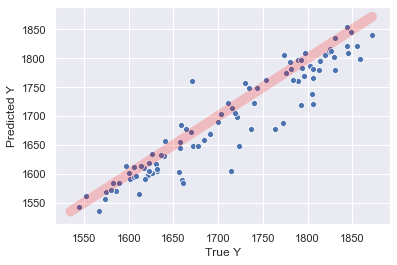

In [554]:
line_x_y = [math.floor(min(y_test.min(),y_hat.min())), math.ceil(max(y_test.max(),y_hat.max()))]
_ = plt.plot(line_x_y, line_x_y, linewidth=10, alpha=0.2, color='red')
_ = sns.scatterplot(y_test, y_hat)
_ = plt.ylabel('Predicted Y')
_ = plt.xlabel('True Y')
plt.show()